# ID5059 P2 - Credit Card Fraud Detection
180016546, 190016302, 220032525, 200002786, 180000622

#### Plan:
1. Setup
2. Explore data
3. Imputing
4. Balancing
5. Present Models
    1. Decision Tree
    2. Decision Tree with ADA Boosting
    3. Logistic Regression
    4. Logistic Regression with SMOTE
    5. Logistic Regression with Elastic Net
6. Evaluation

### 1. Setup
Import required libraries.

In [166]:
import sys
!{sys.executable} -m pip install numpy pandas matplotlib scikit-learn seaborn imblearn | grep -v 'already satisfied'

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sb

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
%matplotlib inline 

SEED = 618

Defaulting to user installation because normal site-packages is not writeable
distutils: /home/fiw/.local/lib/python3.9/site-packages
sysconfig: /home/fiw/.local/lib64/python3.9/site-packages
user = True
home = None
root = None
prefix = None


Read in datasets.

In [167]:
# Read in data
train = pd.read_csv("/cs/studres/ID5059/Coursework/Coursework-2/data/train.csv")
test = pd.read_csv("/cs/studres/ID5059/Coursework/Coursework-2/data/test.csv")

# Clear the maximum number of columns to be displayed, so that all will be visible.
pd.set_option('display.max_columns', None)

train.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,0.742144,0.108782,-1.070243,-0.234910,-1.099360,0.502467,0.169318,0.065688,-0.306957,-0.323800,0.103348,-0.292969,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0
1,1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,-0.109948,0.908773,0.836798,-0.056580,-0.120990,-0.144028,-0.039582,1.653057,-0.253599,-0.814354,0.716784,0.065717,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0
2,2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,-0.042027,-0.818383,-0.376512,-0.226546,-0.552869,-0.886466,-0.180890,0.230286,0.590579,-0.321590,-0.433959,-0.021375,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0
3,3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,0.885838,-0.007527,0.637441,0.676960,-1.504823,0.554039,-0.824356,-0.527267,-0.095838,-0.312519,0.642659,-0.340089,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0
4,4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,0.692665,-0.097495,1.338869,1.391399,-0.128167,-0.081836,0.100548,-0.338937,0.090864,-0.423645,-0.731939,-0.203628,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0


Split `train` data into `X` and `y`.

In [168]:
# set id as index
train = train.set_index('id')
test = test.set_index('id')

- Methods below format the predictions made from a model and then writes the data to a file
- The formatting and output is in order to use kaggle

In [169]:
# Make a function to format results
def output_func(predictions):
    results = pd.DataFrame({'id': test.index, 'Class': predictions[:,1]})
    return results

In [170]:
# Make function to export csv
def export_func (results, filename = 'out'):
    results.to_csv(filename, index = False)

---

### 2. Explore data
Check dataset completeness

In [171]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219129 entries, 0 to 219128
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    219129 non-null  float64
 1   V1      219129 non-null  float64
 2   V2      219129 non-null  float64
 3   V3      219129 non-null  float64
 4   V4      219129 non-null  float64
 5   V5      219129 non-null  float64
 6   V6      219129 non-null  float64
 7   V7      219129 non-null  float64
 8   V8      219129 non-null  float64
 9   V9      219129 non-null  float64
 10  V10     219129 non-null  float64
 11  V11     219129 non-null  float64
 12  V12     219129 non-null  float64
 13  V13     219129 non-null  float64
 14  V14     219129 non-null  float64
 15  V15     219129 non-null  float64
 16  V16     219129 non-null  float64
 17  V17     219129 non-null  float64
 18  V18     219129 non-null  float64
 19  V19     219129 non-null  float64
 20  V20     219129 non-null  float64
 21  V21     219129 

Dataset is complete! All floats except `Class` which is `int`:

In [172]:
train['Class'].unique()

array([0, 1])

`Class` is binary: 0 = no fraud, 1 = fraud. Lets investigate fraud rate in `train`.

In [173]:
# lets just check how much of our train set is fraudulent
fraud = train['Class'].sum()
fraud_percent = fraud/len(train['Class']) * 100

print('fraud:', fraud, '\ntotal entries:', len(train['Class']), '\nfraud rate', round(fraud_percent, 2), '%')

fraud: 469 
total entries: 219129 
fraud rate 0.21 %


Visualise columm value spread.

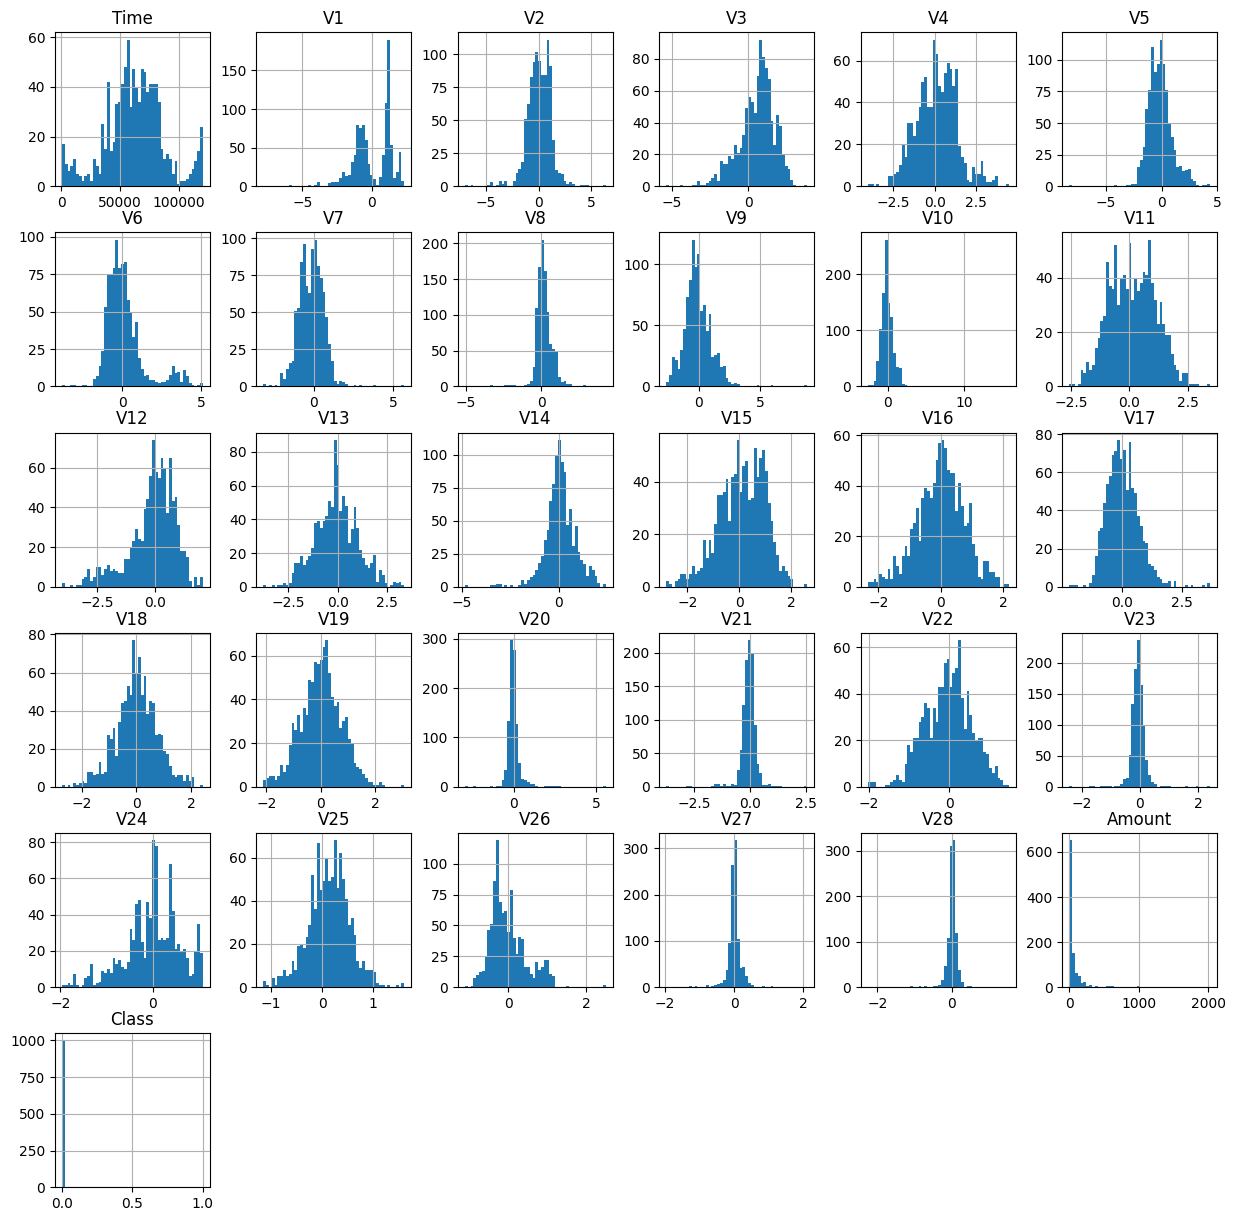

In [174]:
# look at a random subset of data
train_subset = train.sample(1000)
train_subset.hist(bins=50, figsize=(15, 15))
plt.show()

Virtually all columns follow bell curve, meaning fraud cases likely to exist as outliers.

Generate correlation heatmap (TODO: visualise better)

<Axes: >

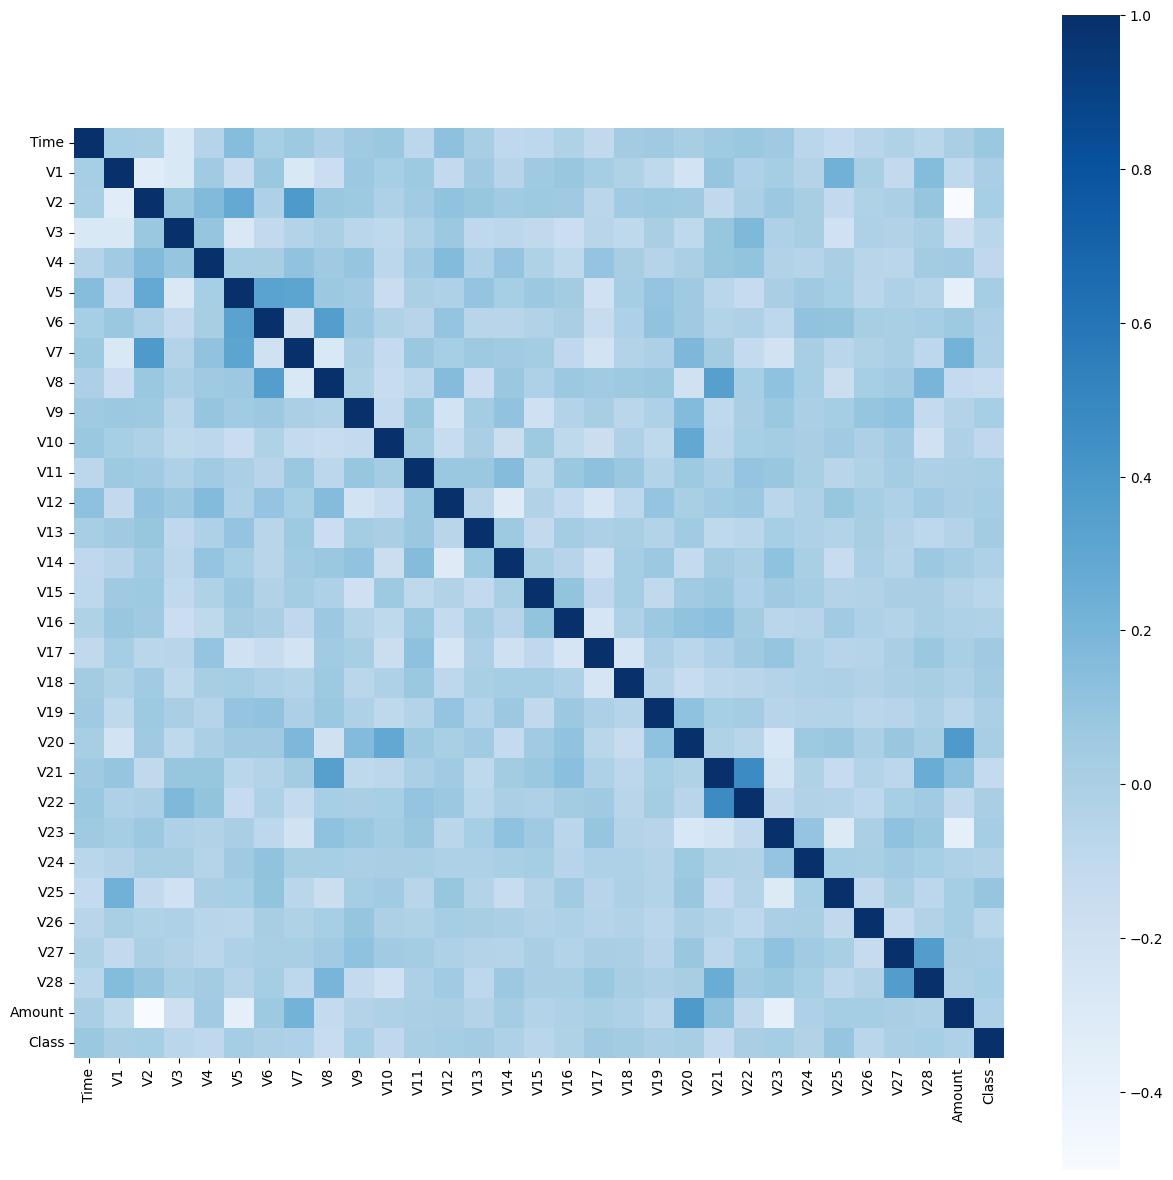

In [175]:
corr = train_subset.corr()
fig, ax = plt.subplots(figsize=(15,15)) 
sb.heatmap(corr, cmap="Blues", ax=ax, square=True)

Focus correlations on `Class`:

In [176]:
cor = train_subset.corr() # correlation coefficients (correlation with price)
pd.DataFrame(abs(cor['Class']).sort_values(ascending=False))

,Class
Class,1.000000
V8,0.134732
V21,0.115771
V4,0.095222
V25,0.094757
V10,0.091263
Time,0.074526
V26,0.070487
V3,0.070029
V15,0.064627


No great correlations present.

---
### 3. Imputing

Since the dataset is already complete we must remove some data first. \
Define method which removes between 10% and 40% of entries in 70% of columns, is seeded.

In [148]:
def remover(df):
  remove_vals = df.copy();
  num_columns = len(remove_vals.columns);
  np.random.seed(SEED)
  rem_columns = round(num_columns * 0.7, 0)
  random_arr = []
  count = 0

  while count < rem_columns :
    r = np.random.randint(1, num_columns - 1);
    if r not in random_arr:
      count += 1;
      random_arr.append(r);

  count = 0;
  for column in remove_vals:
    if count in random_arr:
      random_perc = np.random.uniform(0.1, 0.4);
      cur_mask = np.random.choice([True, False], size= len(remove_vals[column]), p=[random_perc, 1 - random_perc]);
      remove_vals[column] = remove_vals[column].mask(cur_mask);
    count += 1;
      
  return remove_vals

Apply to `X_train`

In [178]:
X_train_remover = remover(train)
X_train_remover.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,0.742144,0.108782,-1.070243,-0.234910,-1.099360,0.502467,0.169318,0.065688,-0.306957,-0.323800,0.103348,-0.292969,-0.334701,NaN,0.336701,-0.110835,NaN,0.207733,-0.076576,NaN,NaN,0
1,0.0,NaN,-1.250891,NaN,-0.894539,-1.122528,-0.270866,NaN,0.050198,-0.109948,0.908773,0.836798,NaN,-0.120990,-0.144028,-0.039582,1.653057,-0.253599,-0.814354,0.716784,0.065717,0.054848,NaN,NaN,-0.461928,-0.465491,-0.464655,NaN,-0.038238,84.00,0
2,0.0,0.091535,NaN,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,-0.042027,-0.818383,-0.376512,NaN,-0.552869,-0.886466,-0.180890,0.230286,0.590579,-0.321590,-0.433959,-0.021375,-0.326725,-0.803736,NaN,0.951233,-0.506919,NaN,0.224458,0.087356,2.69,0
3,0.0,1.979649,-0.184949,NaN,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,0.885838,-0.007527,0.637441,0.676960,NaN,NaN,-0.824356,-0.527267,-0.095838,NaN,0.642659,-0.340089,-0.095514,NaN,NaN,-0.042939,NaN,-0.096148,-0.057780,NaN,1.00,0
4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,NaN,0.692665,-0.097495,1.338869,1.391399,-0.128167,NaN,0.100548,-0.338937,0.090864,-0.423645,-0.731939,NaN,0.099157,0.608908,NaN,-0.262813,NaN,-0.252829,0.108338,NaN,1.00,0


### Imputation Methods
Below are three different forms of imputation methods. For analysis of imputation see ./supporting-docs/Removal and Imputation Section. The methods are as follows:
- Imputation using the Class Mean
- Imputation using an Iterative Imputer: Bayesian Ridge
- Imputation using an Iterative Imputer: Random Forest Regression

In [150]:
#all imports needed for the imputation.
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

- Method below takes in a dataframe and imputes missing data using class mean

In [151]:
#METHOD TO IMPUTE DATA USING CLASS MEAN
def class_mean_imputer(df):
    # compute the mean for each feature and class label
    class_labels = df['Class']
    class_means = []
    for label in np.unique(class_labels):
        class_means.append(df[class_labels == label].mean())

    # impute missing values using class means
    df_class_mean_imputed = SimpleImputer(strategy='mean').fit_transform(df)
    for i in range(len(df)):
        for j in range(len(df.columns)):
            if np.isnan(df_class_mean_imputed[i, j]):
                df_class_mean_imputed[i, j] = class_means[class_labels[i]][j]

    class_mean_imputed = pd.DataFrame(df_class_mean_imputed, index = df.index, columns=df.columns)
    return class_mean_imputed

In [180]:
df_class_mean_imputed = class_mean_imputer(X_train_remover)

display(df_class_mean_imputed)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,0.742144,0.108782,-1.070243,-0.234910,-1.099360,0.502467,0.169318,0.065688,-0.306957,-0.323800,0.103348,-0.292969,-0.334701,-0.051811,0.336701,-0.110835,0.124015,0.207733,-0.076576,0.017472,66.295613,0.0
1,0.0,0.096225,-1.250891,0.591603,-0.894539,-1.122528,-0.270866,-0.129394,0.050198,-0.109948,0.908773,0.836798,-0.060238,-0.120990,-0.144028,-0.039582,1.653057,-0.253599,-0.814354,0.716784,0.065717,0.054848,-0.051811,-0.051534,-0.461928,-0.465491,-0.464655,0.014092,-0.038238,84.000000,0.0
2,0.0,0.091535,0.047872,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,-0.042027,-0.818383,-0.376512,-0.060238,-0.552869,-0.886466,-0.180890,0.230286,0.590579,-0.321590,-0.433959,-0.021375,-0.326725,-0.803736,-0.051534,0.951233,-0.506919,0.009839,0.224458,0.087356,2.690000,0.0
3,0.0,1.979649,-0.184949,0.591603,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,0.885838,-0.007527,0.637441,0.676960,0.013973,0.068956,-0.824356,-0.527267,-0.095838,-0.033634,0.642659,-0.340089,-0.095514,-0.051811,-0.051534,-0.042939,0.124015,-0.096148,-0.057780,0.017472,1.000000,0.0
4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.150019,0.692665,-0.097495,1.338869,1.391399,-0.128167,0.068956,0.100548,-0.338937,0.090864,-0.423645,-0.731939,0.009835,0.099157,0.608908,-0.051534,-0.262813,0.124015,-0.252829,0.108338,0.017472,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219124,120580.0,0.096225,-1.272908,-3.783908,-1.388939,2.012789,2.666080,0.151740,0.401934,-1.102824,0.858158,-0.280639,0.007976,-0.124950,0.914374,0.108121,-2.309929,-0.041423,1.190526,-0.281848,-0.195703,-0.181369,-0.051811,-0.051534,0.756765,0.244479,-0.147566,-0.054725,-0.044588,198.650000,0.0
219125,120580.0,0.139724,0.047872,0.591603,-2.184829,1.883716,-1.056824,1.725624,0.018089,-0.823494,-0.257933,-0.457534,0.516146,-0.071240,1.310799,-1.892909,-0.318780,-0.917395,0.098397,-0.195558,0.009835,0.491469,-0.051811,-0.085398,-0.091409,0.124015,0.467570,0.358918,0.294735,66.295613,0.0
219126,120580.0,2.058343,-0.038993,0.591603,0.330117,0.270127,-0.735664,-0.129394,0.144823,0.849289,-0.136498,0.179926,-0.060238,-3.937694,0.031346,0.028100,0.013854,0.391801,1.007789,-0.008176,-0.384830,-0.306640,-0.965783,0.307799,-0.021434,-0.343989,0.181065,0.014092,-0.044064,1.790000,0.0


- Method below takes in a dataframe and imputes missing data using a Bayesian Ridge Iterative Imputer

In [152]:
#METHOD TO IMPUTE DATA USING BAYESIAN RIDGE II
def bayesian_ridge_imputer(df):
    pipeline = Pipeline([('imputer', IterativeImputer(max_iter=20, random_state=0))]) # decide on best parameters?
    df_II_imputed = pd.DataFrame(pipeline.fit_transform(df), columns = df.columns)
    return df_II_imputed


In [195]:
df_II_BR_imputed = bayesian_ridge_imputer(X_train_remover)

display(df_II_BR_imputed)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,0.742144,0.108782,-1.070243,-0.234910,-1.099360,0.502467,0.169318,0.065688,-0.306957,-0.323800,0.103348,-0.292969,-0.334701,-0.567284,0.336701,-0.110835,0.650931,0.207733,-0.076576,-0.028794,-10.951131,0.0
1,0.0,0.588777,-1.250891,1.866184,-0.894539,-1.122528,-0.270866,-0.689443,0.050198,-0.109948,0.908773,0.836798,-0.925173,-0.120990,-0.144028,-0.039582,1.653057,-0.253599,-0.814354,0.716784,0.065717,0.054848,0.084105,0.026867,-0.461928,-0.465491,-0.464655,0.010714,-0.038238,84.000000,0.0
2,0.0,0.091535,1.197159,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,-0.042027,-0.818383,-0.376512,-0.830053,-0.552869,-0.886466,-0.180890,0.230286,0.590579,-0.321590,-0.433959,-0.021375,-0.326725,-0.803736,0.278648,0.951233,-0.506919,0.338039,0.224458,0.087356,2.690000,0.0
3,0.0,1.979649,-0.184949,0.251659,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,0.885838,-0.007527,0.637441,0.676960,0.195309,0.303818,-0.824356,-0.527267,-0.095838,-0.109630,0.642659,-0.340089,-0.095514,-0.493374,-0.203714,-0.042939,0.476443,-0.096148,-0.057780,0.047920,1.000000,0.0
4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.464586,0.692665,-0.097495,1.338869,1.391399,-0.128167,-0.113424,0.100548,-0.338937,0.090864,-0.423645,-0.731939,-0.172910,0.099157,0.608908,-0.024100,-0.262813,0.451440,-0.252829,0.108338,0.028899,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219124,120580.0,1.895007,-1.272908,-3.783908,-1.388939,2.012789,2.666080,0.151740,0.401934,-1.102824,0.858158,-0.280639,0.007976,-0.124950,0.914374,0.835723,-2.309929,-0.041423,1.190526,-0.281848,-0.195703,-0.181369,-0.293142,0.170554,0.756765,0.244479,-0.147566,-0.054725,-0.044588,198.650000,0.0
219125,120580.0,0.139724,0.082783,0.070916,-2.184829,1.883716,-1.056824,1.725624,0.018089,-0.823494,-0.257933,-0.457534,0.516146,-0.071240,1.310799,-1.892909,-0.318780,-0.917395,0.098397,-0.195558,-0.098522,0.491469,0.130591,-0.085398,-0.091409,0.160080,0.467570,0.358918,0.294735,75.686002,0.0
219126,120580.0,2.058343,-0.038993,-0.884114,0.330117,0.270127,-0.735664,0.228249,0.144823,0.849289,-0.136498,0.179926,-0.552062,-3.937694,0.031346,0.028100,-0.216386,0.391801,1.007789,-0.087973,-0.384830,-0.306640,-0.965783,0.307799,-0.021434,-0.343989,0.181065,-0.003500,-0.044064,1.790000,0.0
219127,120580.0,2.079227,-2.162389,-1.785833,-2.804889,0.552845,4.038013,-2.155900,1.023785,-0.865242,1.536193,-0.058879,-0.885949,0.019410,-0.425730,0.665556,-0.009179,0.301966,0.391249,0.037770,-0.190984,0.109909,0.210581,0.227764,0.675660,-0.510736,0.142935,0.056749,-0.017126,88.000000,0.0


- Method below takes in a dataframe and imputes missing data using a Random Forest Regression Iterative Imputer

In [153]:
#METHOD TO IMPUTE DATA USING RANDOM FOREST REGRESSION II
def rForest_imputer(df):

    rf_regressor = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, 
                                            max_samples=0.5, n_jobs=2, random_state=0) # tuned hyperparameters
    pipeline = Pipeline([('imputer', IterativeImputer(estimator=rf_regressor, 
                              missing_values=np.nan, 
                              random_state=123))]) 
    df_II_imputed = pd.DataFrame(pipeline.fit_transform(df), columns = df.columns)
    return df_II_imputed


In [196]:
df_II_RF_imputed = rForest_imputer(X_train_remover)
df_II_RF_imputed

/home/fiw/.local/lib/python3.9/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,0.742144,0.108782,-1.070243,-0.234910,-1.099360,0.502467,0.169318,0.065688,-0.306957,-0.323800,0.103348,-0.292969,-0.334701,-0.827770,0.336701,-0.110835,-0.297509,0.207733,-0.076576,-0.063147,15.300808,0.0
1,0.0,0.973126,-1.250891,0.692820,-0.894539,-1.122528,-0.270866,-1.004083,0.050198,-0.109948,0.908773,0.836798,0.060720,-0.120990,-0.144028,-0.039582,1.653057,-0.253599,-0.814354,0.716784,0.065717,0.054848,0.113316,0.069490,-0.461928,-0.465491,-0.464655,0.014239,-0.038238,84.000000,0.0
2,0.0,0.091535,0.969157,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,-0.042027,-0.818383,-0.376512,-0.329637,-0.552869,-0.886466,-0.180890,0.230286,0.590579,-0.321590,-0.433959,-0.021375,-0.326725,-0.803736,0.069490,0.951233,-0.506919,0.092332,0.224458,0.087356,2.690000,0.0
3,0.0,1.979649,-0.184949,-1.402640,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,0.885838,-0.007527,0.637441,0.676960,-0.841852,0.079206,-0.824356,-0.527267,-0.095838,-0.072995,0.642659,-0.340089,-0.095514,-0.108935,-0.046463,-0.042939,0.354581,-0.096148,-0.057780,-0.065169,1.000000,0.0
4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.474468,0.692665,-0.097495,1.338869,1.391399,-0.128167,0.041700,0.100548,-0.338937,0.090864,-0.423645,-0.731939,-0.108745,0.099157,0.608908,-0.009454,-0.262813,0.354708,-0.252829,0.108338,0.024087,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219124,120580.0,1.955202,-1.272908,-3.783908,-1.388939,2.012789,2.666080,0.151740,0.401934,-1.102824,0.858158,-0.280639,0.007976,-0.124950,0.914374,0.258272,-2.309929,-0.041423,1.190526,-0.281848,-0.195703,-0.181369,-0.924500,-0.104232,0.756765,0.244479,-0.147566,-0.054725,-0.044588,198.650000,0.0
219125,120580.0,0.139724,0.210710,-0.376562,-2.184829,1.883716,-1.056824,1.725624,0.018089,-0.823494,-0.257933,-0.457534,0.516146,-0.071240,1.310799,-1.892909,-0.318780,-0.917395,0.098397,-0.195558,0.080506,0.491469,0.984557,-0.085398,-0.091409,-0.621898,0.467570,0.358918,0.294735,82.462194,0.0
219126,120580.0,2.058343,-0.038993,-1.537967,0.330117,0.270127,-0.735664,-0.008224,0.144823,0.849289,-0.136498,0.179926,-0.253695,-3.937694,0.031346,0.028100,-0.663816,0.391801,1.007789,-0.234422,-0.384830,-0.306640,-0.965783,0.307799,-0.021434,-0.343989,0.181065,-0.084745,-0.044064,1.790000,0.0
219127,120580.0,2.079227,-2.162389,-1.785833,-2.804889,0.552845,4.038013,-2.155900,1.023785,-0.865242,1.536193,-0.058879,-0.885949,0.172283,-0.425730,0.665556,-0.048511,0.301966,0.391249,0.037770,-0.190984,0.109909,0.399376,0.248198,0.675660,-0.510736,-0.061196,0.056749,-0.017126,88.000000,0.0


### Imputation Methods Comparison

In [198]:
# set df = train (original, complete set) for convenience
df = train
df_del = X_train_remover

# df dimensions = NxM
N = df.shape[0]
M = df.shape[1]

# Obtain the columns for which there was missing data that has been imputed (other columns do not need to be analysed)
df_diff = df.compare(df_del)
relevant_cols = df_diff.columns.get_level_values(0).unique().tolist()

# defining functions to compare the errors in our imputation methods:

def get_errors(df,df_imputed):
    Es = (df[relevant_cols]-df_imputed[relevant_cols])
    MSEs = (Es**2).mean(0)
    RMSEs = MSEs**0.5
    RMSEs_perc = 100*RMSEs/abs(np.mean(df[relevant_cols]))
    MAEs = abs(Es).sum() / N
    MAEs_perc = 100*MAEs/abs(np.mean(df[relevant_cols]))
    errors = pd.concat([MSEs,RMSEs,RMSEs_perc,MAEs,MAEs_perc], axis=1)
    errors.columns = ['MSE','RMSE','RMSE %','MAE','MAE %']
    return errors.transpose()

def get_mean_RMSE_perc(df,df_imputed):
    Es = (df[relevant_cols]-df_imputed[relevant_cols])
    MSEs = (Es**2).mean(0)
    RMSEs = MSEs**0.5
    RMSEs_perc = 100*RMSEs/abs(np.mean(df[relevant_cols]))
    mean_RMSEs_perc = np.mean(RMSEs_perc)
    return mean_RMSEs_perc

def get_mean_MAE_perc(df,df_imputed):
    Es = (df[relevant_cols]-df_imputed[relevant_cols])
    MAEs = abs(Es).sum() / N
    MAEs_perc = 100*MAEs/abs(np.mean(df[relevant_cols]))
    mean_MAEs_perc = np.mean(MAEs_perc)
    return mean_MAEs_perc

Now we will compare the errors for each of our imputation methods using plots to visualize the differences:

In [199]:
# Errors in class mean imputer:
get_errors(df,df_class_mean_imputed)

,V1,V2,V3,V7,V8,V11,V12,V13,V14,V15,V16,V18,V19,V20,V22,V23,V24,V25,V26,V27,V28,Amount
MSE,0.341580,0.264666,0.292299,0.177656,0.110107,0.319198,0.368948,0.266251,0.162467,0.126744,0.167980,0.155234,0.093550,0.043828,0.118502,0.036549,0.077329,0.059480,0.040475,0.015863,0.009548,4131.043276
RMSE,0.584448,0.514457,0.540647,0.421493,0.331824,0.564976,0.607411,0.515995,0.403072,0.356011,0.409854,0.393998,0.305860,0.209350,0.344242,0.191179,0.278081,0.243886,0.201183,0.125947,0.097714,64.273193
RMSE %,19.064853,16.781709,17.636039,13.749200,10.824178,18.429668,19.813903,16.831891,13.148294,11.613156,13.369537,12.852298,9.977215,6.829062,11.229252,6.236296,9.071086,7.955621,6.562637,4.108424,3.187454,2096.607572
MAE,0.202974,0.157481,0.197591,0.166348,0.079388,0.272876,0.274840,0.198911,0.143218,0.113888,0.165830,0.151269,0.097314,0.051864,0.157991,0.059247,0.099388,0.114974,0.067017,0.036313,0.028712,12.542978
MAE %,6.621047,5.137070,6.445460,5.426318,2.589647,8.901299,8.965357,6.488540,4.671803,3.715053,5.409406,4.934447,3.174421,1.691816,5.153712,1.932663,3.242066,3.750495,2.186105,1.184536,0.936602,409.155087


In [200]:
# Errors in iterative imputer using a Bayesian Ridge:
get_errors(df,df_II_BR_imputed)

,V1,V2,V3,V7,V8,V11,V12,V13,V14,V15,V16,V18,V19,V20,V22,V23,V24,V25,V26,V27,V28,Amount
MSE,0.227938,0.142708,0.189250,0.097241,0.112562,0.304225,0.302229,0.280552,0.149555,0.137130,0.153793,0.160077,0.100312,0.031349,0.142399,0.041652,0.076809,0.055040,0.045926,0.016322,0.010682,1185.661574
RMSE,0.477429,0.377767,0.435029,0.311835,0.335503,0.551566,0.549753,0.529672,0.386724,0.370310,0.392164,0.400097,0.316721,0.177057,0.377358,0.204088,0.277145,0.234607,0.214305,0.127759,0.103352,34.433437
RMSE %,15.573848,12.322839,14.190749,10.172148,10.944202,17.992206,17.933089,17.278030,12.615035,12.079612,12.792504,13.051254,10.331524,5.775639,12.309518,6.657416,9.040526,7.652929,6.990669,4.167528,3.371379,1123.227300
MAE,0.111145,0.077650,0.133441,0.089770,0.063313,0.242080,0.211678,0.198068,0.119403,0.108256,0.139059,0.139563,0.091939,0.036087,0.134098,0.053593,0.099020,0.099570,0.065718,0.033025,0.028263,7.039819
MAE %,3.625581,2.532973,4.352870,2.928306,2.065273,7.896719,6.904978,6.461025,3.894972,3.531325,4.536134,4.552573,2.999070,1.177155,4.374295,1.748214,3.230051,3.247997,2.143722,1.077275,0.921932,229.640654


In [201]:
# Errors in iterative imputer using a Random Forest regressor:
get_errors(df,df_II_RF_imputed)

,V1,V2,V3,V7,V8,V11,V12,V13,V14,V15,V16,V18,V19,V20,V22,V23,V24,V25,V26,V27,V28,Amount
MSE,0.063242,0.063360,0.074388,0.036485,0.029174,0.201069,0.115858,0.138059,0.056002,0.065664,0.052823,0.055770,0.047242,0.018129,0.019684,0.026336,0.024044,0.025529,0.018704,0.011796,0.008559,850.612613
RMSE,0.251481,0.251715,0.272741,0.191009,0.170804,0.448407,0.340380,0.371562,0.236647,0.256250,0.229833,0.236157,0.217351,0.134643,0.140299,0.162282,0.155060,0.159779,0.136762,0.108608,0.092513,29.165264
RMSE %,8.203358,8.210994,8.896879,6.230767,5.571668,14.627158,11.103270,12.120460,7.719478,8.358947,7.497221,7.703494,7.090057,4.392075,4.576591,5.293689,5.058087,5.212033,4.461217,3.542825,3.017795,951.378180
MAE,0.056091,0.053718,0.085202,0.058051,0.036868,0.192134,0.137424,0.132861,0.081897,0.076653,0.079370,0.084112,0.064134,0.031703,0.051069,0.041708,0.048914,0.063644,0.037625,0.028126,0.022044,4.843318
MAE %,1.829711,1.752305,2.779307,1.893648,1.202651,6.267468,4.482796,4.333946,2.671508,2.500438,2.589055,2.743740,2.092082,1.034160,1.665890,1.360525,1.595587,2.076084,1.227335,0.917477,0.719065,157.990248


In [216]:
mean_RMSE_percs

[106.63087937992914, 61.65772473226689, 50.0121019563248]

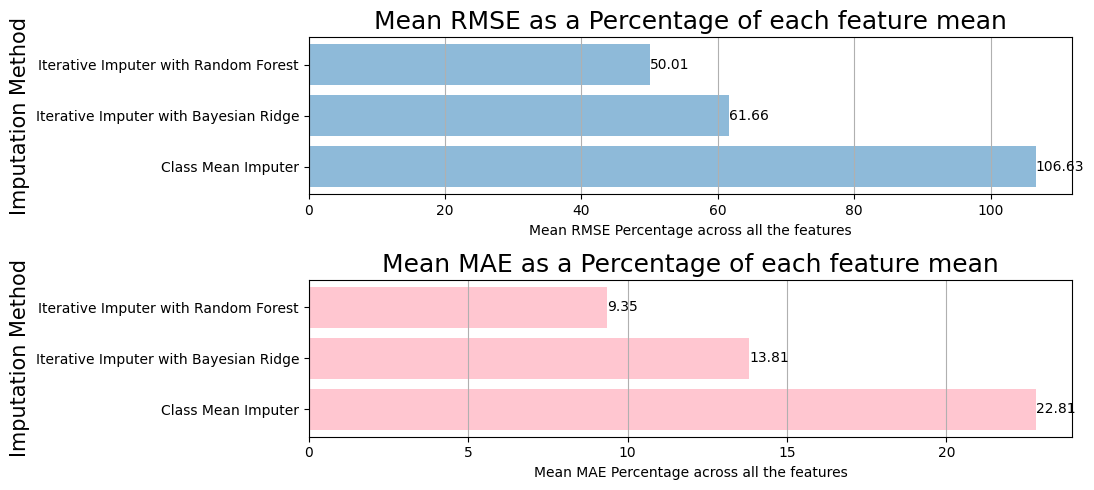

In [202]:
# Bar Charts to compare the RMSE and MAE error across all features

imputed = [df_class_mean_imputed, df_II_BR_imputed, df_II_RF_imputed]
mean_RMSE_percs = [get_mean_RMSE_perc(df, df_imputed) for df_imputed in imputed]
mean_MAE_percs = [get_mean_MAE_perc(df, df_imputed) for df_imputed in imputed]

positions = np.arange(3)
labels = ['Class Mean Imputer', 'Iterative Imputer with Bayesian Ridge', 'Iterative Imputer with Random Forest']

fig, axes = plt.subplots(2,1,figsize=(11,5))
ax1,ax2 = axes.flatten()

# RMSE Bar Plot
bc1 = ax1.barh(width = mean_RMSE_percs, y=positions, align='center', alpha=0.5, capsize=10, label='Mean RMSE %')

ax1.set_title('Mean RMSE as a Percentage of each feature mean', fontsize=18)
ax1.set_xlabel('Mean RMSE Percentage across all the features')
ax1.set_ylabel('Imputation Method', fontsize=15)
ax1.xaxis.grid(True)
ax1.set_yticks(positions)
ax1.set_yticklabels(labels, fontsize=10)

# Add value labels to the bars 
for bar in bc1:     
    value = bar.get_width()
    ax1.text(value, bar.get_y() + bar.get_height() / 2, f'{value:.2f}',
            ha='left', va='center')

# MAE Bar Plot
bc2 = ax2.barh(width = mean_MAE_percs, y=positions, align='center', color='pink', alpha=0.9, capsize=10)

ax2.set_title('Mean MAE as a Percentage of each feature mean', fontsize=18)
ax2.set_xlabel('Mean MAE Percentage across all the features')
ax2.set_ylabel('Imputation Method', fontsize=15)
ax2.xaxis.grid(True)
ax2.set_yticks(positions)
ax2.set_yticklabels(labels, fontsize=10)

# Add value labels to the bars 
for bar in bc2:     
    value = bar.get_width()
    ax2.text(value, bar.get_y() + bar.get_height() / 2, f'{value:.2f}',
            ha='left', va='center')

fig.tight_layout()
plt.show()

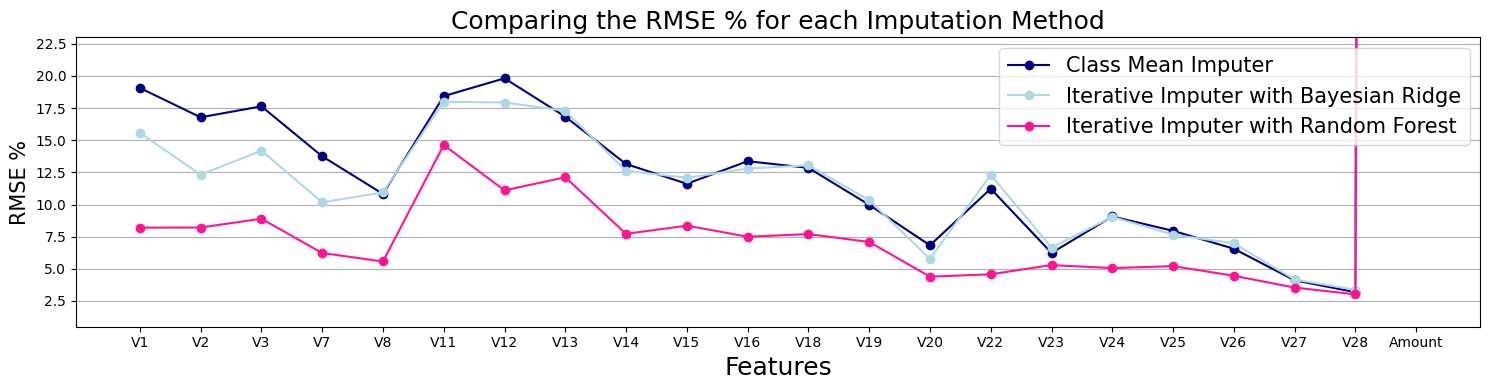

In [210]:
# Plotting the RMSE % of each feature to compare the 3 imputation methods

class_mean_errors = get_errors(df,df_class_mean_imputed).loc['RMSE %']
bayesian_ridge_errors = get_errors(df,df_II_BR_imputed).loc['RMSE %']
random_forest_errors = get_errors(df,df_II_RF_imputed).loc['RMSE %']

fig, ax = plt.subplots(1,1,figsize=(15,4))
ax.plot(class_mean_errors, label='Class Mean Imputer', marker='o', color='navy')
ax.plot(bayesian_ridge_errors, label='Iterative Imputer with Bayesian Ridge', marker='o', color='lightblue')
ax.plot(random_forest_errors, label='Iterative Imputer with Random Forest', marker='o', color='deeppink')
ax.set_ylim(0.5, 23) # otherwise the large error in 'Time' hides the results
ax.set_title('Comparing the RMSE % for each Imputation Method', fontsize=18)
ax.set_xlabel('Features',fontsize=18)
ax.set_ylabel('RMSE %',fontsize=15)
ax.yaxis.grid(True)
ax.legend(fontsize=15)
fig.tight_layout()
plt.show()


- The line graph above shows the error for the random forest iterative imputer has much smaller errors across all features.
- So, this will be our chosen imputation method:

In [211]:
X_train_imputed = df_II_RF_imputed

### Exploring our final Imputed Data

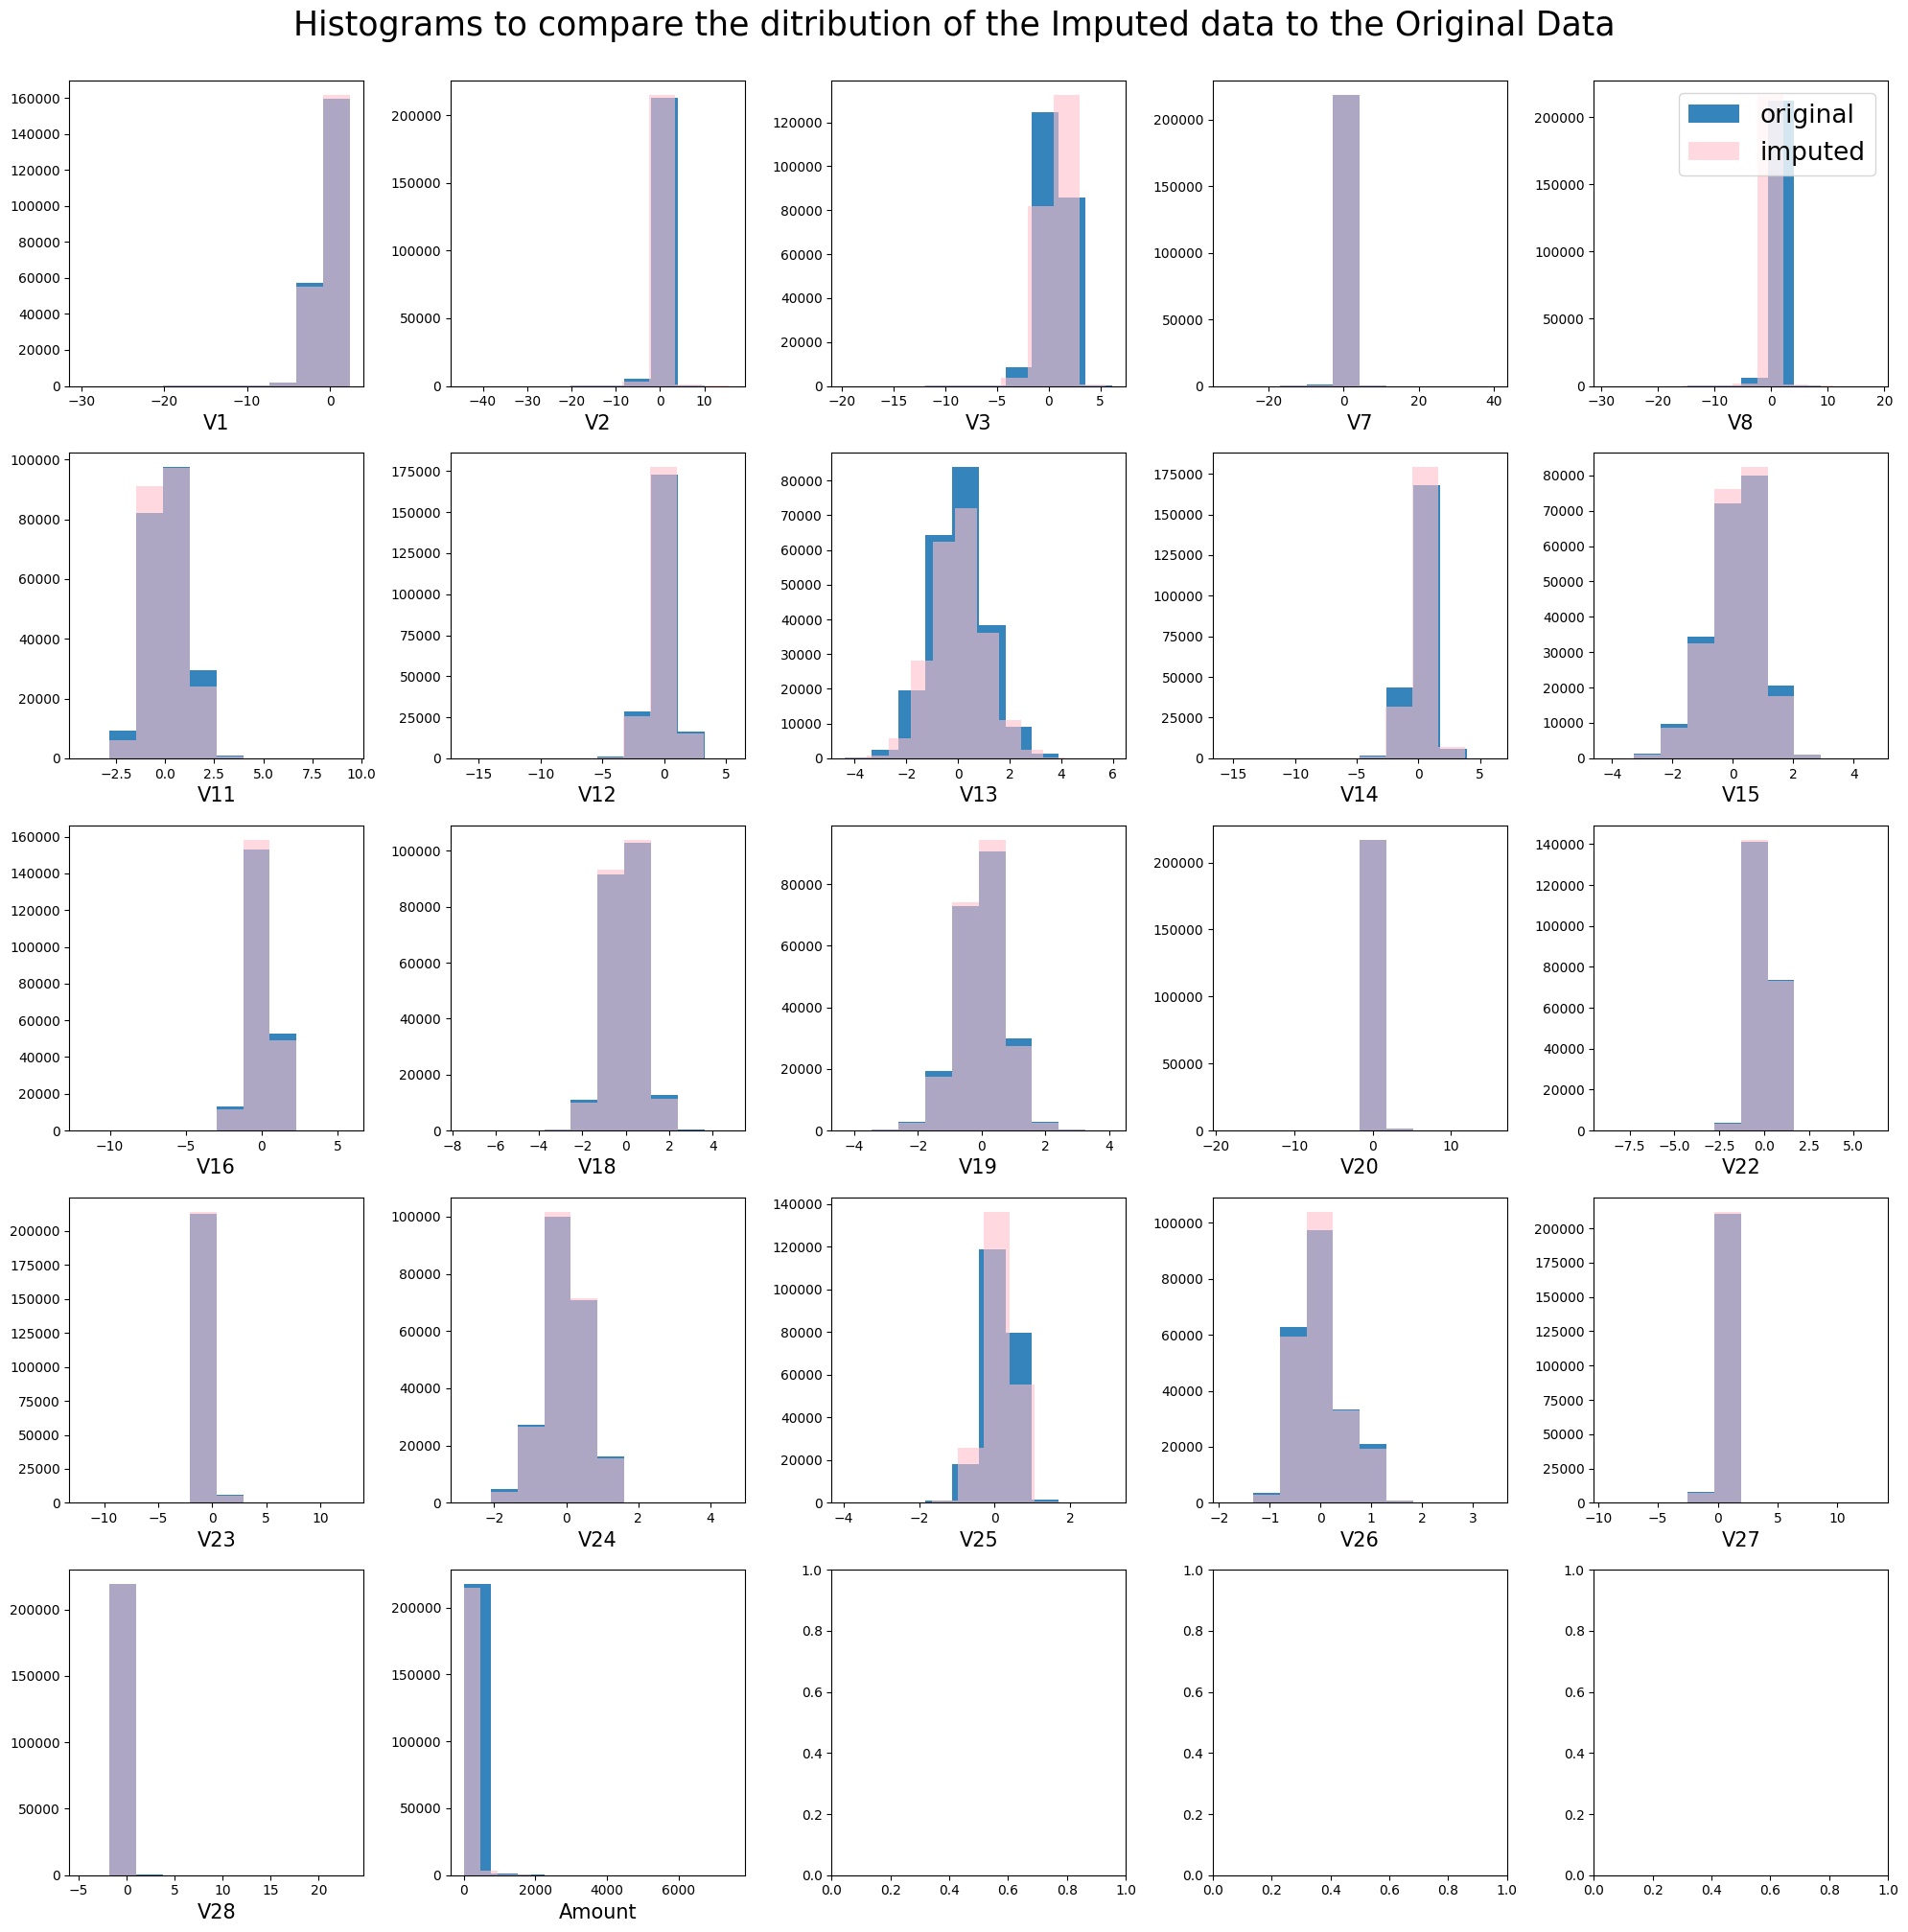

In [213]:
# Histograms to compare the ditribution of the Imputed data to the Original Data
fig, axes = plt.subplots(5,5, figsize=(20,20))
axes = axes.flatten()

for i in range(len(relevant_cols)):
    axes[i].hist(df[relevant_cols[i]], bins=10, alpha=0.9, label='original')
    axes[i].hist(X_train_imputed[relevant_cols[i]], bins=10, alpha=0.6, label='imputed', color='pink')
    axes[i].set_xlabel(f'{relevant_cols[i]}', fontsize=15)
plt.suptitle('Histograms to compare the ditribution of the Imputed data to the Original Data', fontsize=25, y=1.005)

fig.tight_layout()
axes[4].legend(loc = 'upper right', fontsize=19)
plt.show()

### Error Scatter Plots

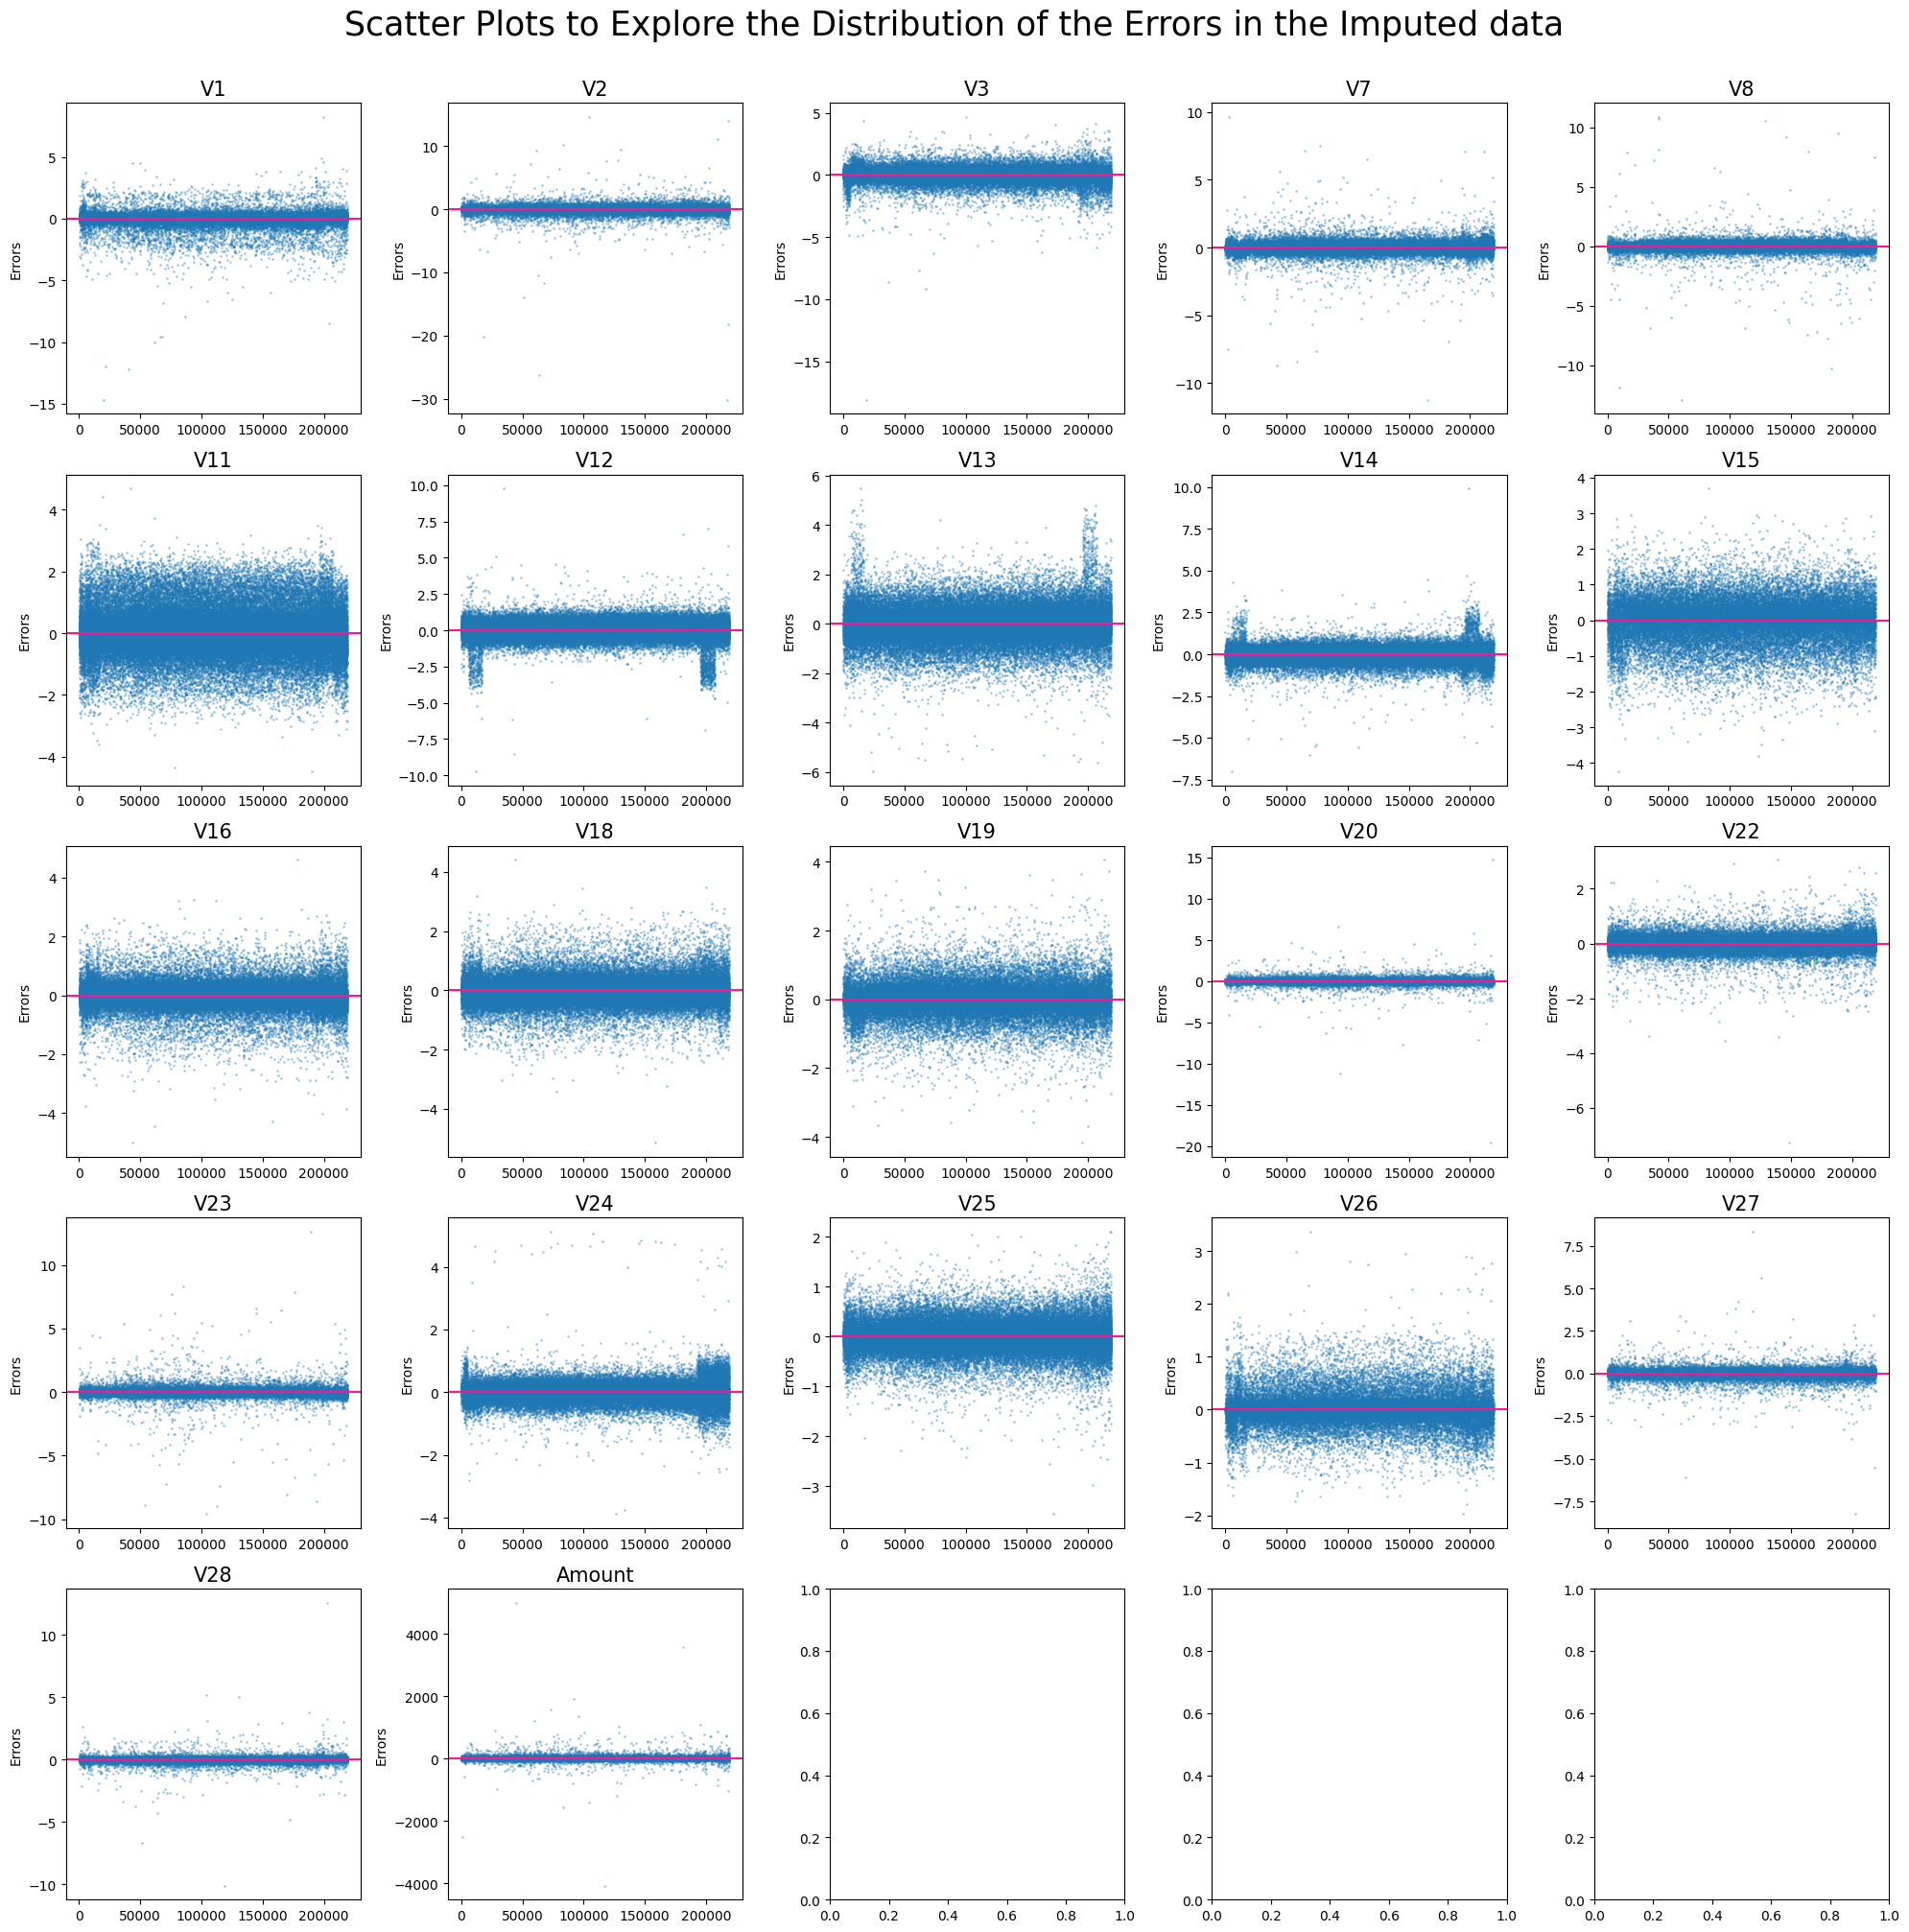

In [214]:
# Obtain the errors in each values of our imputed data
Es = df[relevant_cols]-X_train_imputed[relevant_cols]

# Scatter Plots to Explore the Distribution of the Errors in the Imputed data
fig, axes = plt.subplots(5,5, figsize=(20,20))
axes = axes.flatten()

for i in range(len(relevant_cols)):
    axes[i].scatter( list(range(N)),Es[relevant_cols[i]], s=1, alpha=0.3)
    axes[i].axhline(y=0, color='deeppink') # zero error line

    axes[i].set_title(f'{relevant_cols[i]}', fontsize=15)
    axes[i].set_ylabel('Errors')

plt.suptitle('Scatter Plots to Explore the Distribution of the Errors in the Imputed data',y=1.005, fontsize=25)
fig.tight_layout()
plt.show()

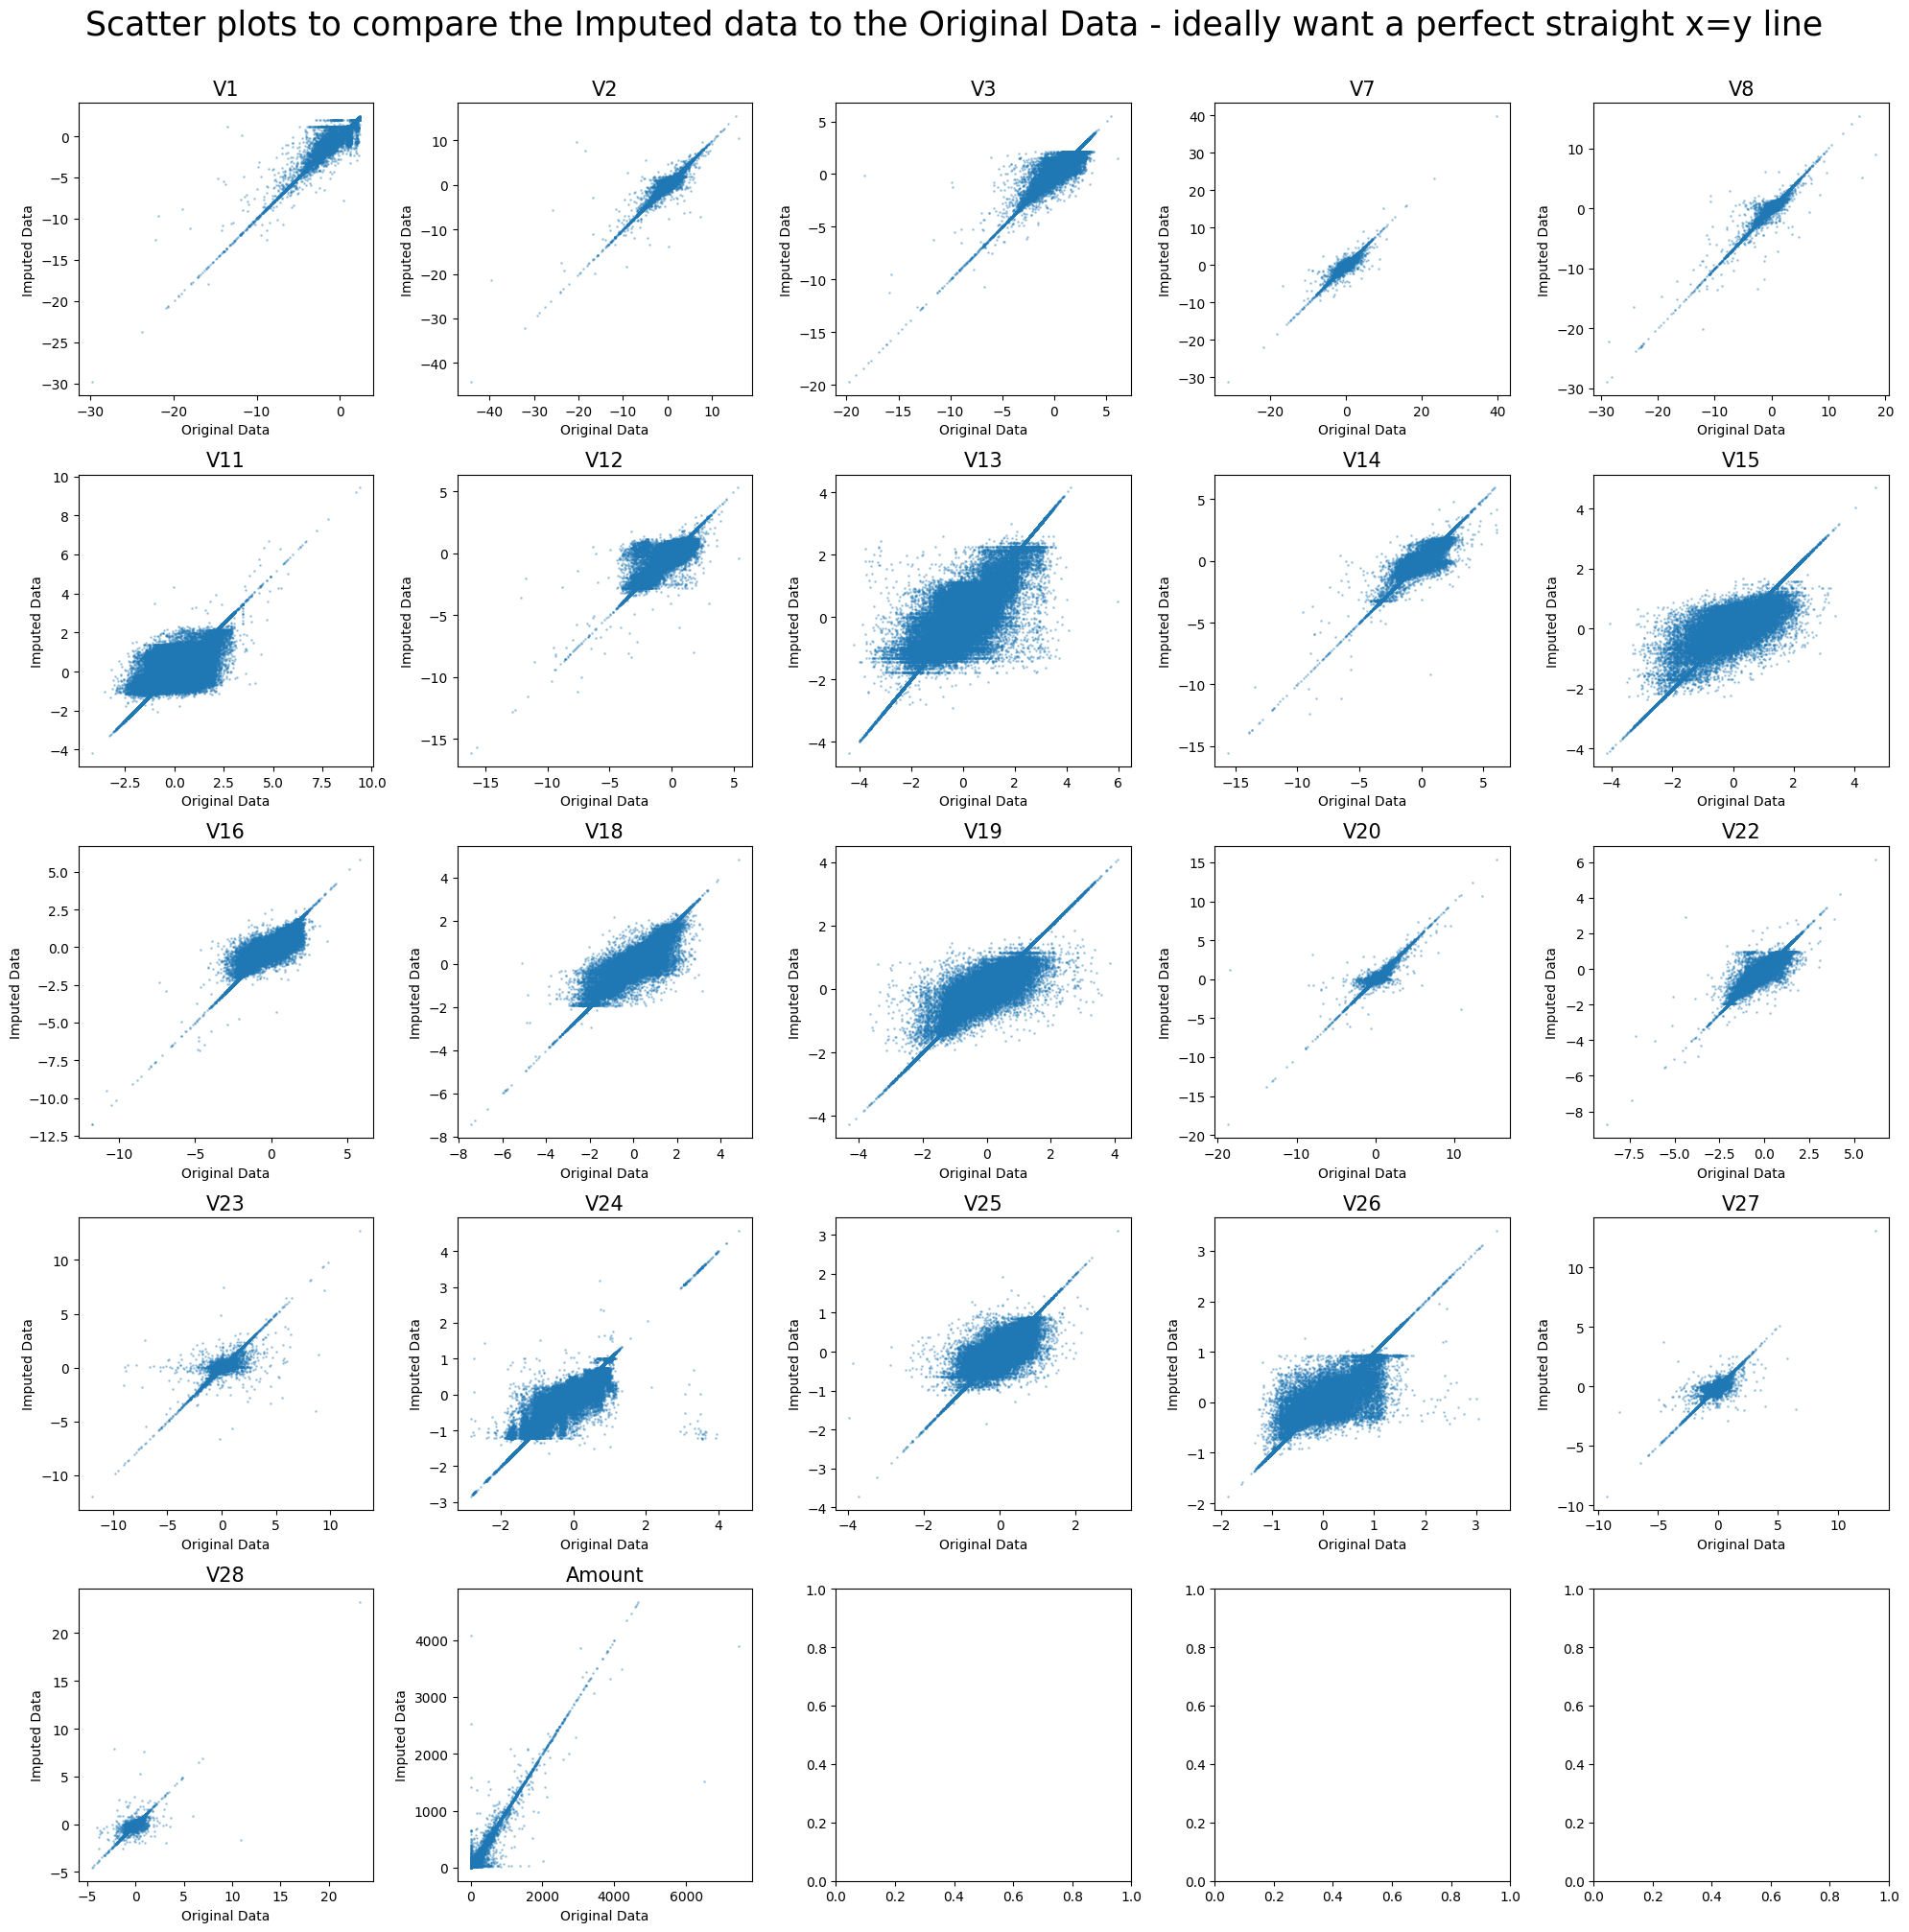

In [215]:
# Scatter plots to compare the Imputed data to the Original Data - ideally want a perfect straight x=y line
fig, axes = plt.subplots(5,5, figsize=(20,20))
axes = axes.flatten()

for i in range(len(relevant_cols)):
    axes[i].scatter(df[relevant_cols[i]], X_train_imputed[relevant_cols[i]], s=1, alpha=0.3)
    axes[i].set_title(f'{relevant_cols[i]}', fontsize=15)
    axes[i].set_xlabel('Original Data')
    axes[i].set_ylabel('Imputed Data')
    axes[i].plot()

plt.suptitle('Scatter plots to compare the Imputed data to the Original Data - ideally want a perfect straight x=y line', fontsize=25, y=1.005)
fig.tight_layout()
plt.show()

---
### 4. Present models
We trained on basic models before trying to improve results using different methods such as ADA boosting and SMOTE balancing.

In [217]:
# remove lables from training data
y_train = train['Class']
X_train = train.drop('Class', axis = 1)

display(X_train)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,0.742144,0.108782,-1.070243,-0.234910,-1.099360,0.502467,0.169318,0.065688,-0.306957,-0.323800,0.103348,-0.292969,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98
1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,-0.109948,0.908773,0.836798,-0.056580,-0.120990,-0.144028,-0.039582,1.653057,-0.253599,-0.814354,0.716784,0.065717,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00
2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,-0.042027,-0.818383,-0.376512,-0.226546,-0.552869,-0.886466,-0.180890,0.230286,0.590579,-0.321590,-0.433959,-0.021375,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69
3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,0.885838,-0.007527,0.637441,0.676960,-1.504823,0.554039,-0.824356,-0.527267,-0.095838,-0.312519,0.642659,-0.340089,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00
4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,0.692665,-0.097495,1.338869,1.391399,-0.128167,-0.081836,0.100548,-0.338937,0.090864,-0.423645,-0.731939,-0.203628,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219124,120580.0,1.891079,-1.272908,-3.783908,-1.388939,2.012789,2.666080,0.151740,0.401934,-1.102824,0.858158,-0.280639,0.007976,-0.124950,0.914374,-0.073169,-2.309929,-0.041423,1.190526,-0.281848,-0.195703,-0.181369,-0.456538,-0.069571,0.756765,0.244479,-0.147566,-0.054725,-0.044588,198.65
219125,120580.0,0.139724,0.948649,-2.913655,-2.184829,1.883716,-1.056824,1.725624,0.018089,-0.823494,-0.257933,-0.457534,0.516146,-0.071240,1.310799,-1.892909,-0.318780,-0.917395,0.098397,-0.195558,-0.116538,0.491469,1.478823,-0.085398,-0.091409,-1.053488,0.467570,0.358918,0.294735,24.00
219126,120580.0,2.058343,-0.038993,-1.928553,0.330117,0.270127,-0.735664,-0.173878,0.144823,0.849289,-0.136498,0.179926,-1.769641,-3.937694,0.031346,0.028100,0.883566,0.391801,1.007789,0.303376,-0.384830,-0.306640,-0.965783,0.307799,-0.021434,-0.343989,0.181065,-0.098387,-0.044064,1.79


#### 4.1. Decision Tree


Using cross validation to find best params for model. 
- `criterion` is set to 'entropy' as it handles imbalanced data better than 'gini' at the cost of computational cost. 
- `min_samples_leaf` has been set to 100, 200 to stop overfitting.
- `max_depth` is being cross validated to see if capping the depth stops overfitting.

In [218]:
params = { 
           'criterion':        ['entropy'], 
           'min_samples_leaf': [100, 200],
           'max_depth':        [25, 50, None]
         }

tree1 = GridSearchCV(tree.DecisionTreeClassifier(), params, cv=2, scoring= 'roc_auc')
tree_train = tree1.fit(X_train, y_train)
tree_best_params = tree_train.best_estimator_
tree_best_params

DecisionTreeClassifier(criterion='entropy', max_depth=25, min_samples_leaf=200)

Can use CV results to predict fruad probabilities on entries in the test set (and export to csv)

In [219]:
tree_train_predictions= tree_best_params.predict_proba(test)

# Create a new DataFrame with 'id' and 'predicted' columns and export to csv .
tree_train_results = output_func(tree_train_predictions)
export_func(tree_train_results, './results/tree_train_results.csv')

In [220]:
# let's also fit to the imputed training data using the best paramters selected above
tree2 = DecisionTreeClassifier(max_depth=25, min_samples_leaf=100)
tree_imputed = tree2.fit(X_train_imputed, y_train)

## Cross Validation Score
Compute a cross validation score using Area under the Reciver-Operator Curve (roc-auc) scoring

In [221]:
# set maximum number of folds
num_folds = 5

# create stratified k-fold object
strat_kfold = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state = SEED)

In [222]:
# do stratfied cv on train set 
tree_train_cv = cross_val_score(tree_train, X_train, y_train, cv=strat_kfold, scoring='roc_auc')

# do stratfied cv on imputed set 
tree_imputed_cv = cross_val_score(tree_train, X_train_imputed, y_train, cv=strat_kfold, scoring='roc_auc')

In [223]:
# compute the mean score
tree_meanCV = tree_train_cv.mean()
tree_imputed_meanCV = tree_imputed_cv.mean()

# save CV scores for comparison
tree_cv_comp = pd.DataFrame({'Original': [tree_meanCV], 'Imputed': [tree_imputed_meanCV]}, index=['Decision Tree'])

display(tree_cv_comp)

,Original,Imputed
Decision Tree,0.670678,1.0


#### 4.2. Decision Tree with ADA Boosting
After limiting `max_depth` and `min_samples_leaf` the Decision Tree performs pretty well. \
Lets try an alternative method for implementing a Decision Tree by creating a stump and using that with an ADA Boost Classifier to see if that performs better.

Steps:
- Create a simple decision tree fitted with the training data 
- The decision tree can be passed into the ADA boost classifier 
- The parameters in ADA boost have been calculated using GridSearch and cross validation 

In [224]:
decision_tree_simple = DecisionTreeClassifier(max_depth = 1, random_state = SEED);
decision_tree_simple.fit(X_train, y_train)

ada_final = AdaBoostClassifier(decision_tree_simple, n_estimators = 150, algorithm = "SAMME.R", learning_rate = 0.1, random_state = SEED);
ada_train = ada_final.fit(X_train, y_train)

In [225]:
# fit to the imputed data
decision_tree_simple2 = DecisionTreeClassifier(max_depth = 1, random_state = SEED);
decision_tree_simple2.fit(X_train_imputed, y_train)

ada2 = AdaBoostClassifier(decision_tree_simple2, n_estimators = 150, algorithm = "SAMME.R", learning_rate = 0.1, random_state = SEED);
ada_imputed = ada2.fit(X_train_imputed, y_train)

Get the probabilities that each item is fraudulent by using `predict_proba` \
Probabilities are then put into a new dataframe which is formatted for Kaggle

In [226]:
ada_predictions = ada_train.predict_proba(test)

# Create a new DataFrame with 'id' and 'predicted' columns and export to csv.
ada_results = output_func(ada_predictions)
export_func(ada_results, './results/ada_results.csv')

##### Cross Validation for Ada Boost

- perform cross validation on the ada boost model

In [227]:
# perform cross validation

num_folds = 5

# create stratfied k-fold object
strat_kfold = StratifiedKFold(n_splits = num_folds, shuffle=True, random_state=SEED)

# do stratified k fold on original train
ada_cv = cross_val_score(ada_train, X_train, y_train, cv = strat_kfold, scoring='roc_auc')

# do stratified k fold on imputed data
ada_imputed_cv = cross_val_score(ada_imputed, X_train_imputed, y_train, cv = strat_kfold, scoring='roc_auc')

ada_meanCV = ada_cv.mean()
ada_imputed_meanCV = ada_imputed_cv.mean()

In [228]:
# store results for comparison 
# save CV scores for comparison
ada_cv_comp = pd.DataFrame({'Original': [ada_meanCV], 'Imputed': [ada_imputed_meanCV]}, index=['Ada Boost'])

display(ada_cv_comp)

,Original,Imputed
Ada Boost,0.81734,1.0


#### 4.3. Logistic Regression
Logisitic regression requires centered and scaled data.

In [229]:
# Scale the training data
scaler_train = StandardScaler()
X_train_scaled = scaler_train.fit_transform(X_train)

# Scale the imputed data 
X_train_imputed_scaled = scaler_train.fit_transform(X_train_imputed)

In [230]:
# Create logisitic regression object and fit on scaled train
logi_mod1 = LogisticRegression(random_state=SEED)
logi_train = logi_mod1.fit(X_train_scaled, y_train)

# Do stratified k fold on original train
strat_kfold = StratifiedKFold(n_splits = 5, shuffle=True, random_state=SEED)
logi_train_cv = cross_val_score(logi_train, X_train_scaled, y_train, cv = strat_kfold, scoring='roc_auc')

logi_train_meanCV = logi_train_cv.mean()

In [231]:
# Create logisitic regression object and fit on scaled imputed data
logi_mod2 = LogisticRegression(random_state=SEED)
logi_imputed = logi_mod2.fit(X_train_imputed_scaled, y_train)

# Do stratified k fold on original train
strat_kfold = StratifiedKFold(n_splits = 5, shuffle=True, random_state=SEED)
logi_imputed_cv = cross_val_score(logi_imputed, X_train_imputed_scaled, y_train, cv = strat_kfold, scoring='roc_auc')

logi_imputed_meanCV = logi_imputed_cv.mean()

In [232]:
logi_cv_comp = pd.DataFrame({'Original': [logi_train_meanCV], 'Imputed': [logi_imputed_meanCV]}, index= ['Logistic'])
display(logi_cv_comp)

,Original,Imputed
Logistic,0.792744,1.0


In [233]:
# Scale the test data
X_test_scaled = scaler_train.transform(test)

# Predict on test
predicted_logi_train = logi_train.predict_proba(X_test_scaled)

# Export to csv for output to kaggle
logi_train_kaggle = output_func(predicted_logi_train)
export_func(logi_train_kaggle, './results/logi_train_kaggle.csv')

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Class


#### 4.4. Logistic Regression with Elastic Net

In [ ]:
# Scale the training data
scaler_elastic = StandardScaler()
X_elastic_scaled = scaler_elastic.fit_transform(X_train)

In [ ]:

# define logisitc regressor with elastic net
logi_elastic_train = LogisticRegression(C = 0.1, l1_ratio= 0.9, penalty='elasticnet', solver='saga', max_iter=500)
logi_elastic = logi_elastic_train.fit(X_elastic_scaled, y_train)



In [ ]:
# Train the best model on the imputed data
logi_elastic_train2 = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=500, C = 0.1, l1_ratio= 0.9)
logi_elastic_imputed = logi_elastic_train2.fit(X_train_imputed_scaled, y_train)

#### Cross Validation

In [ ]:
# perform cross validation on train set for elastic logistic regression

num_folds = 5

# create stratfied k-fold object
strat_kfold = StratifiedKFold(n_splits = num_folds, shuffle=True, random_state=SEED)
logi_elastic_cv = cross_val_score(logi_elastic, X_elastic_scaled, y_train, cv = strat_kfold, scoring = 'roc_auc')


logi_elastic_meanCV = logi_elastic_cv.mean()

In [ ]:
# perform cross validation on imputed set

num_folds = 5

# create stratfied k-fold object
strat_kfold = StratifiedKFold(n_splits = num_folds, shuffle=True, random_state=SEED)
logi_elastic_imputed_cv = cross_val_score(logi_elastic_imputed, X_train_imputed_scaled, y_train, cv = strat_kfold, scoring = 'roc_auc')


logi_elastic_imputed_meanCV = logi_elastic_imputed_cv.mean()

- comparing the mean cross-validation between the original data and the imputed data

In [ ]:
logi_elastic_cv_comp = pd.DataFrame({'Original': [logi_elastic_meanCV], 'Imputed': [logi_elastic_imputed_meanCV]}, index= ['Logistic (Elastic)'])
display(logi_elastic_cv_comp)

,Original,Imputed
Logistic (Elastic),0.793202,0.786266


In [ ]:
# fit to the test data and export for kaggle marking
X_test_elastic_scaled = scaler_elastic.transform(test)

# Predict on elastic test
predicted_logi_elastic = logi_elastic.predict_proba(X_test_elastic_scaled)

# Export to CSV
logi_elastic_kaggle = output_func(predicted_logi_elastic)
export_func(logi_elastic_kaggle, './results/logi_elastic_kaggle.csv')

#### 4.5. Logistic Regression with SMOTE balancing
Following the same structure as normal logistic regression, but first we must use SMOTE on the training dataset to oversample fraudulant entries, then balance with an under sampler to balance distribution.

In [ ]:
# apply SMOTE to oversample the minority class on the original data
smote = SMOTE(sampling_strategy='minority')
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

# apply random undersampling to balance the class distribution
rus = RandomUnderSampler(sampling_strategy='majority')
X_train_SMOTE, y_train_SMOTE = rus.fit_resample(X_train_SMOTE, y_train_SMOTE)

In [ ]:
# lets just check how much of our resampled set is fraudulent
fraud_bal = y_train_SMOTE.sum()
fraud_percent_bal = fraud_bal / len(y_train_SMOTE) * 100

print('new fraud', fraud_bal, '\ntotal entries', len(y_train_SMOTE), '\nnew fraud rate', fraud_percent_bal, '%')

new fraud 218660 
total entries 437320 
new fraud rate 50.0 %


In [ ]:
# apply SMOTE to oversample the minority class on the imputed data
smote = SMOTE(sampling_strategy='minority')
X_imputed_SMOTE, y_imputed_SMOTE = smote.fit_resample(X_train_imputed, y_train)

# apply random undersampling to balance the class distribution
rus = RandomUnderSampler(sampling_strategy='majority')
X_imputed_SMOTE, y_imputed_SMOTE = rus.fit_resample(X_imputed_SMOTE, y_imputed_SMOTE)

Now proceed the same as a regular logistic regression but with the new SMOTE datasets.

In [ ]:
# Scale the training data
scaler_SMOTE = StandardScaler()
X_SMOTE_scaled = scaler_SMOTE.fit_transform(X_train_SMOTE)

scaler_imputed_SMOTE = StandardScaler()
X_SMOTE_imputed_scaled = scaler_SMOTE.fit_transform(X_imputed_SMOTE)

In [ ]:
# Create logistic regression object and fit on scaled SMOTE train
logi_mod2 = LogisticRegression(random_state=SEED)
logi_SMOTE = logi_mod2.fit(X_SMOTE_scaled, y_train_SMOTE)

# Do stratified k fold on SMOTE train
strat_kfold = StratifiedKFold(n_splits = 5, shuffle=True, random_state=SEED)
logi_SMOTE_cv = cross_val_score(logi_SMOTE, X_SMOTE_scaled, y_train_SMOTE, cv = strat_kfold, scoring='roc_auc')

logi_SMOTE_meanCV = logi_SMOTE_cv.mean()

In [ ]:
X_test_SMOTE_scaled = scaler_SMOTE.transform(test)

# Predict on SMOTE test
predicted_logi_SMOTE = logi_SMOTE.predict_proba(X_test_SMOTE_scaled)

# Export to CSV
logi_SMOTE_kaggle = output_func(predicted_logi_SMOTE)
export_func(logi_SMOTE_kaggle, './results/logi_SMOTE_kaggle.csv')

In [ ]:
# Create logistic regression object and fit on scaled SMOTE imputed data
logi_mod2 = LogisticRegression(random_state=SEED)
logi_SMOTE_imputed = logi_mod2.fit(X_SMOTE_scaled, y_train_SMOTE)

# Do stratified k fold on SMOTE train
strat_kfold = StratifiedKFold(n_splits = 5, shuffle=True, random_state=SEED)
logi_SMOTE_imputed_cv = cross_val_score(logi_SMOTE_imputed, X_SMOTE_imputed_scaled, y_train_SMOTE, cv = strat_kfold, scoring='roc_auc')

logi_SMOTE_imputed_meanCV = logi_SMOTE_cv.mean()

- comparing the mean cross-validation between the original data and the imputed data

In [ ]:
# store the mean Cvs for comparison
logi_SMOTE_cv_comp = pd.DataFrame({'Original': [logi_SMOTE_meanCV], 'Imputed': [logi_SMOTE_imputed_meanCV]}, index= ['Logistic (SMOTE)'])
display(logi_SMOTE_cv_comp)

,Original,Imputed
Logistic (SMOTE),0.867222,0.867222


---
### 6. Evaluation

To evaluate, we will display all the cross validation scores (roc-auc) in a table

In [ ]:
# Create a dictionary with the data frames and their names
dfs = {'Decision Tree': tree_cv_comp, 'Logistic Regression': logi_cv_comp, 
'SMOTE Logistic Regression': logi_SMOTE_cv_comp, 'Elastic Net Logistic Regression': logi_elastic_cv_comp, 'AdaBoost': ada_cv_comp}

# Concatenate the data frames along the row axis
result = pd.concat(dfs.values(), axis=0)

# Print the resulting data frame
print(result.T)

# export as csv
result.to_csv('CrossVal_Table.csv')

          Decision Tree  Logistic  Logistic (SMOTE)  Logistic (Elastic)   
Original       0.672866  0.792744          0.867222            0.793202  \
Imputed        0.667911  0.786200          0.867222            0.786266   

          Ada Boost  
Original   0.817340  
Imputed    0.811206  


In [ ]:
#Ada Train results
ada_predictions = ada_train.predict_proba(test)

# Create a new DataFrame with 'id' and 'predicted' columns and export to csv.
ada_results = output_func(ada_predictions)
export_func(ada_results, './results/ada_results.csv')

In [ ]:
#Ada imputed results
ada_imputed = ada_final.fit(X_train_imputed, y_train)

ada_imputed_predictions = ada_imputed.predict_proba(test)

# Create a new DataFrame with 'id' and 'predicted' columns and export to csv.
ada_imputed_results = output_func(ada_imputed_predictions)
export_func(ada_imputed_results, './results/ada_imputed_results.csv')

In [ ]:
# SMOTE Train Results
X_test_SMOTE_scaled = scaler_SMOTE.transform(test)

# Predict on SMOTE test
predicted_logi_SMOTE = logi_SMOTE.predict_proba(X_test_SMOTE_scaled)

# Export to CSV
logi_SMOTE_kaggle = output_func(predicted_logi_SMOTE)
export_func(logi_SMOTE_kaggle, './results/logi_SMOTE_kaggle.csv')

In [ ]:
# SMOTE Imputed Results
scaler_imputed_SMOTE = StandardScaler()
X_SMOTE_imputed_scaled = scaler_imputed_SMOTE.fit_transform(X_imputed_SMOTE)
X_test_imputed_scaled = scaler_imputed_SMOTE.transform(test)

# Predict on SMOTE test
predicted_logi_SMOTE_imputed = logi_SMOTE.predict_proba(X_test_imputed_scaled )

# Export to CSV
logi_SMOTE_imputed_kaggle = output_func(predicted_logi_SMOTE_imputed)
export_func(logi_SMOTE_imputed_kaggle, './results/logi_SMOTE_imputed_kaggle.csv')

In [ ]:
# fit to the test data and export for kaggle marking
X_test_elastic_scaled = scaler_elastic.transform(test)

# Predict on elastic test
predicted_logi_elastic = logi_elastic.predict_proba(X_test_elastic_scaled)

# Export to CSV
logi_elastic_kaggle = output_func(predicted_logi_elastic)
export_func(logi_elastic_kaggle, './results/logi_elastic_kaggle.csv')

In [ ]:
# fit imputed elastic net model  to the test data and export for kaggle marking
# Scale the imputed data 
scaler_elastic_imputed = StandardScaler()
X_train_imputed_scaled = scaler_elastic_imputed.fit_transform(X_train_imputed)
X_test_imputed_elastic_scaled = scaler_elastic_imputed.transform(test)

# Predict on elastic test
predicted_logi_imputed_elastic = logi_elastic.predict_proba(X_test_imputed_elastic_scaled)

# Export to CSV
logi_imputed_elastic_kaggle = output_func(predicted_logi_imputed_elastic)
export_func(logi_imputed_elastic_kaggle, './results/logi_imputed_elastic_kaggle.csv')